In [1]:
import numpy as np
from scipy import integrate
from scipy.misc import derivative
from scipy.linalg import eig
import matplotlib.pyplot as plt

pi = np.pi

# Método de Rayleigth-Ritz

![image](\img\esquematico.png)

In [2]:
# Definição dos parâmetros da viga
L = 1.5                             # Comprimento da viga [m]
rho = 7700                          # Densidade do material [kg/m**3]
E = 2.1e11                          # Modulo de elasticidade [Pa]
A1 = pi * 0.03**2 / 4               # Área da seção 1 [m**2]
A2 = pi * 0.06**2 / 4               # Área da seção 2 [m**2]
A3 = pi * 0.03**2 / 4               # Área da seção 3 [m**2]
I1 = (pi/4)*(0.03/2)**4             # Momento da seção 1 [m**4] 
I2 = (pi/4)*(0.06/2)**4             # Momento da seção 2 [m**4]
I3 = (pi/4)*(0.03/2)**4             # Momento da seção 3 [m**4]
m_eng = 20                          # Massa da engrenagem [kg]
J_eng = 0.25 * m_eng * 0.1**2       # Momento de inercia de massa da engreagem [kg*m**2]
k_mola = 2*10e3                     # Rigidez esquivalente das molas em paralelo [N/m]

# Definição das funções base d_j(x)
def eta(j):
    if j==1:
        return 1.875/L
    if j>1:
        return (j-0.5)*pi/L

def D(etaj):
    etajL = etaj*L
    return ((np.cos(etajL) + np.cosh(etajL))/(np.sin(etajL) - np.sinh(etajL))).tolist()

def d(x, etaj):
    etajx = etaj*x
    D_ = D(etaj)
    # Foi necessário reformular para evitar erros de arredondamento
    return np.sin(etajx) + D_*np.cos(etajx) - 0.5*((D_ - 1)*np.exp(-etajx) + (D_ + 1)*np.exp(etajx))

## Determinando as matrizes de massa e rigidez

In [3]:
n = np.array([4, 8, 12, 16])               # Array com os numeros de funcoes base
N = np.max(n)                              # No. de funcoes que serao utilizadas para montar as matrizes K e M
K = np.zeros((N, N))                       # Pre-alocando matriz de rigidez
M = np.zeros((N, N))                       # Pre-alocando matriz de massa

L1 = np.linspace(0, L/3, 50000)            # Primeiro trecho da viga, para integração numérica
L2 = np.linspace(L/3, 2*L/3, 50000)
L3 = np.linspace(2*L/3, L, 50000)

didj = lambda x, i, j: d(x, eta(i))*d(x, eta(j))
diff2 = lambda x, i, j: derivative(d, x, n=2, dx=1e-6, args = (eta(i),))*derivative(d, x, n=2, dx=1e-6, args = (eta(j),))

for i in range(1, N+1):
    for j in range(i, N+1):

        M[i-1, j-1] = rho*A1*integrate.simpson(didj(L1, i, j), L1) \
            + rho*A2*integrate.simpson(didj(L2, i, j), L2) \
            + rho*A3*integrate.simpson(didj(L3, i, j), L3) \
            + m_eng*d(L/3, eta(i))*d(L/3, eta(j)) \
            + J_eng*derivative(d, L/3, dx=1e-6, args = (eta(i),))*derivative(d, L/3, dx=1e-6, args = (eta(j),))

        K[i-1, j-1] = E*I1*integrate.simpson(diff2(L1, i, j), L1) \
            + E*I2*integrate.simpson(diff2(L2, i, j), L2) \
            + E*I3*integrate.simpson(diff2(L3, i, j), L3) \
            + k_mola*d(2*L/3, eta(i))*d(2*L/3, eta(j))

# Espelhando a matriz
M = (M + M.T - np.diag(np.diagonal(M))).real
K = (K + K.T - np.diag(np.diagonal(K))).real

## Calculando Autovalores e Autovetores a partir de [K] e [M]

In [4]:
resultados = dict()
x = np.linspace(0, L, int(L/0.001 + 1)) # Pontos onde a resposta será calculada

# Calculando as funções base nos pontos x
d_arr = np.zeros((n.max(), x.size))
for j in range(1, N+1):
    d_arr[j-1,:] = d(x, eta(j))

for N in n:
    # Problema de autovalor generalizado. W é um vetor e A uma matriz com as colunas normalizadas (norm=1)
    W, A = eig(K[:N, :N], M[:N, :N])

    # Ordenando os autovalores e a matriz de autovetores
    idx = W.argsort()
    W = W[idx].real
    A = A[:,idx].real

    # Normalizando os autovetores pela matriz de massa, de forma que A' @ M @ A = I
    m_r = np.diagonal(A.T @ M[:N, :N] @ A)
    m_r = np.reciprocal(np.sqrt(m_r))
    for a in range(A.shape[1]):
        A[:,a] *= m_r[a] # multiplica cada coluna pelo fator de escala    
    
    dj = d_arr[:N, :] # recorta o array até número de funções desejadas

    # Faz as formas modais terem a mesma orientação, analisando o sinal da covariância
    phi = dj.T @ A
    try:
        for k in range(N): # k-ésimo modo
            cov = np.cov(resultados[n[0]]['V'][:,k], phi[:,k])[0][1]
            cov = cov/np.abs(cov) # -1 ou 1
            phi[:,k] *= cov
    except:
        pass
        
    # Armazena em um dicionário
    resultados[N] = dict()
    resultados[N]['V'] = phi
    resultados[N]['fn'] = np.real(W**0.5/(2*np.pi))
    resultados[N]['d'] = dj

# Funções de base

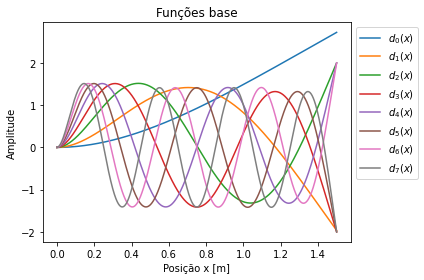

In [5]:
N = n[1]
for i in range(N):
    plt.plot(x, resultados[N]['d'][i], label=f'$d_{i}(x)$')

plt.title('Funções base')
plt.xlabel('Posição x [m]')
plt.ylabel('Amplitude')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.grid(True)
plt.tight_layout()
plt.savefig("img/funcoes_de_base.svg")
plt.show()

# Formas Modais

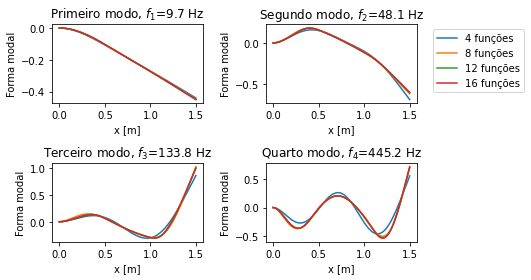

In [6]:
fig, axs = plt.subplots(2,2)

for n_b in n:
    axs[0,0].set_title(f"Primeiro modo, $f_1$={resultados[n_b]['fn'][0]:.1f} Hz")
    axs[0,0].plot(x, resultados[n_b]['V'][:,0], label=f"{n_b} funções")
    axs[0,0].set_xlabel('x [m]')
    axs[0,0].set_ylabel('Forma modal')
    
    axs[0,1].set_title(f"Segundo modo, $f_2$={resultados[n_b]['fn'][1]:.1f} Hz")
    axs[0,1].plot(x, resultados[n_b]['V'][:,1])
    axs[0,1].set_xlabel('x [m]')
    axs[0,1].set_ylabel('Forma modal')

    axs[1,0].set_title(f"Terceiro modo, $f_3$={resultados[n_b]['fn'][2]:.1f} Hz")
    axs[1,0].plot(x, resultados[n_b]['V'][:,2])
    axs[1,0].set_xlabel('x [m]')
    axs[1,0].set_ylabel('Forma modal')

    axs[1,1].set_title(f"Quarto modo, $f_4$={resultados[n_b]['fn'][3]:.1f} Hz")
    axs[1,1].plot(x, resultados[n_b]['V'][:,3])
    axs[1,1].set_xlabel('x [m]')
    axs[1,1].set_ylabel('Forma modal')

fig.legend(loc='upper left', bbox_to_anchor=(1, 0.9))
fig.tight_layout()
plt.savefig("img/comparacao_das_formas_modais.svg")
plt.show()

## Comparação das frequências naturais

In [7]:
import pandas as pd
pd.options.display.float_format = "{:.2f}".format
pd.DataFrame(data=[resultados[n_b]['fn'] for n_b in n], index=[f"n={i}" for i in n], columns=[f"f_{j}" for j in range(1, n.max()+1)])

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,f_11,f_12,f_13,f_14,f_15,f_16
n=4,9.85,61.39,218.68,506.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n=8,9.73,51.02,147.71,449.84,681.93,839.65,1515.87,2333.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n=12,9.71,48.97,136.75,446.54,633.47,803.22,1281.28,1829.31,2004.04,2859.91,4715.18,5673.22,NaN,NaN,NaN,NaN
n=16,9.70,48.07,133.79,445.15,620.92,785.39,1264.21,1754.97,1912.75,2813.96,3561.87,3837.44,5311.90,6391.26,9081.09,10033.78


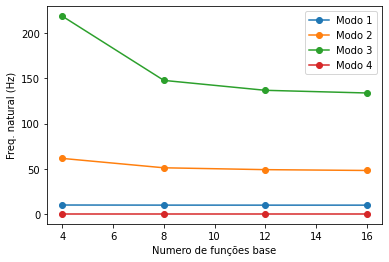

In [8]:
fn_N=np.zeros((4, len(n)))
for j in range(0,3):
    for k in range(len(n)):
        fn_N[j, k] = resultados[n[k]]['fn'][j]
        
for k in range(fn_N[1,:].size):
    plt.plot(n, fn_N[k,:], marker='o')
plt.xlabel('Numero de funções base')
plt.ylabel('Freq. natural (Hz)')
plt.legend(['Modo 1', 'Modo 2','Modo 3', 'Modo 4'])
# plt.yscale('log')
# plt.grid(True)
fig.tight_layout()
plt.savefig("img/comparacao_das_freq_naturais.svg")
plt.show()